## Policy measures analysis
In this notebook multiple policies can be tested, based on a chosen problem formulations. The effects on deaths and costs are summerized at the end of the notebook.

### Imports
Import packages and load model parameters (uncertainties, levers, etc.)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [2]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.4.2
2.8.2


In [3]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation


def sum_over(*args):
    return sum(args)

In [4]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

**Problem formulation**
Important cell below, here you can choose the problem formulation number, between 0-5
each problem formulation has its own list of outcomes

In [5]:
used_problem_formulation = 3

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [6]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [7]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

In [8]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.1_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2'), function=<function sum_over at 0x000001D4C9C0E5E0>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths 0', 'A.1_Expected Number of Deaths 1', 'A.1_Expected Number of Deaths 2'), function=<function sum_over at 0x000001D4C9C0E5E0>)
ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage 0', 'A.2_Expected Annual Damage 1', 'A.2_Expected Annual Damage 2', 'A.2_Dike Investment Costs 0', 'A.2_Dike Investment Costs 1', 'A.2_Dike Investment Costs 2'), function=<function sum_over at 0x000001D4C9C0E5E0>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths 0', 'A.2_Expected Number of Deaths 1', 'A.2_Expected Number of Deaths 2'), function=<function sum_over at 0

### Policy formulations
In the following cells the wanted policies can be adjusted

In [9]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In the following policies formulations:
- `RfR` says if the Room for River projects are enabled (projects `0` to `5`). The first number indicated the project, the second (after `RfR`) if in which time step the measure it taken (currently `0` to `2`). The value can be either `0` (not enabled) or `1` (enabled).
- `A.1` to `A.5` are the different dikes. `A.3` is the dike ring around Zutphen. The number after `DikeIncrease` is again the timestep, the value assigned to the thing the heightening in decimeters.
- Early Warning Systems can also be enabled, with `EWS_DaysToThreat`, which specifies the early warning time in days.

See the implementation in problem_formulation.py (starting from line 35) for more details.

In [10]:
pol_list = []
pol_list.append(create_policy({}, name="Zero"))

for meter in [5, 10]:
    pol_list.append(create_policy({"A.3_DikeIncrease 0": meter}, name=f"Dike_A.3_{meter}"))
    
for location in [2, 3, 4]:
    for ews_days in [0, 4]:
        pol_list.append(create_policy({f"{location}_RfR 0": 1, "EWS_DaysToThreat": ews_days}, name=f"RfR_{location}_EWS_{ews_days}_days"))


### Run the model (or load the data)
In the next cell the model is ran (if `use_pickle1 = False`) and the new results data is saved, or, if `use_pickle1 = True`, the saved results data is loaded.

In [11]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = False

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 5
    with MultiprocessingEvaluator(dike_model, n_processes=7) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, pol_list)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 5 scenarios * 9 policies * 1 model(s) = 45 experiments
100%|██████████████████████████████████████████| 45/45 [00:49<00:00,  1.11s/it]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


### Process the results
In this section a dataframe is generated with all the outcomes data, and aggegrated to mean, min, max and quantiles values for each policy.

In [12]:
# Create a dataframe from outcomes, and add the policy column to it
exp, out = results
df = pd.DataFrame(out)
df["policy"] = pd.DataFrame(exp)["policy"]
df

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,policy
0,9.927341e+07,0.071198,3.885037e+07,0.037368,1.979117e+08,0.354365,8.857264e+07,0.039899,8.715384e+08,0.737811,0.0,0.000000,Policy_Zero
1,0.000000e+00,0.000000,7.087811e+08,0.672294,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,Policy_Zero
2,1.993515e+09,1.469681,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,Policy_Zero
3,0.000000e+00,0.000000,6.829223e+06,0.007001,1.517690e+09,2.664630,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,Policy_Zero
4,2.106635e+09,1.472499,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,Policy_Zero
5,9.927341e+07,0.071198,3.885037e+07,0.037368,2.879840e+07,0.000000,8.988583e+07,0.040961,8.715384e+08,0.737811,0.0,0.000000,Policy_Dike_A.3_5
6,0.000000e+00,0.000000,7.087811e+08,0.672294,2.879840e+07,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,Policy_Dike_A.3_5
7,1.993515e+09,1.469681,0.000000e+00,0.000000,2.879840e+07,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,Policy_Dike_A.3_5
8,0.000000e+00,0.000000,6.829223e+06,0.007001,8.343347e+07,0.103713,5.729706e+05,0.000334,1.194263e+08,0.113250,0.0,0.000000,Policy_Dike_A.3_5
9,2.106635e+09,1.472499,0.000000e+00,0.000000,2.879840e+07,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000,Policy_Dike_A.3_5


In [13]:
# Define two functions to get the 5th and 95th quantiles
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

In [14]:
# Create a Pandas GroupBy object
group_df = df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create a dictionary with what outcome values are aggegrated with which functions
agg_dict = {
    "A.3 Total Costs": agg_par,
    "A.3_Expected Number of Deaths": agg_par,
    "RfR Total Costs": agg_par,
    "Expected Evacuation Costs": agg_par,
}
# Create new dataframe with the aggegrated data per policy
TCA_df = group_df.agg(agg_dict)
TCA_df

A.3 Total Costs                              \
                                   mean           min           max   
policy                                                                
Policy_Dike_A.3_10         4.421502e+07  4.421502e+07  4.421502e+07   
Policy_Dike_A.3_5          3.972541e+07  2.879840e+07  8.343347e+07   
Policy_RfR_2_EWS_0_days    3.007634e+08  0.000000e+00  1.434966e+09   
Policy_RfR_2_EWS_4_days    3.007634e+08  0.000000e+00  1.434966e+09   
Policy_RfR_3_EWS_0_days    3.151944e+08  0.000000e+00  1.478223e+09   
Policy_RfR_3_EWS_4_days    3.151944e+08  0.000000e+00  1.478223e+09   
Policy_RfR_4_EWS_0_days    3.356393e+08  0.000000e+00  1.507968e+09   
Policy_RfR_4_EWS_4_days    3.356393e+08  0.000000e+00  1.507968e+09   
Policy_Zero                3.431203e+08  0.000000e+00  1.517690e+09   

                                                     \
                                  q05           q95   
policy                                                
Policy_Dike_A.3_10       4.421502e+07  4.421502e+07   
Policy_Dike_A.3_5        2.879840e+07  7.250646e+07   
Policy_RfR_2_EWS_0_days  0.000000e+00  1.161743e+09   
Policy_RfR_2_EWS_4_days  0.000000e+00  1.161743e+09   
Policy_RfR_3_EWS_0_days  0.000000e+00  1.202128e+09   
Policy_RfR_3_EWS_4_days  0.000000e+00  1.202128e+09   
Policy_RfR_4_EWS_0_days  0.000000e+00  1.240420e+09   
Policy_RfR_4_EWS_4_days  0.000000e+00  1.240420e+09   
Policy_Zero              0.000000e+00  1.253734e+09   

                        A.3_Expected Number of Deaths                      \
                                                 mean  min       max  q05   
policy                                                                      
Policy_Dike_A.3_10                           0.000000  0.0  0.000000  0.0   
Policy_Dike_A.3_5                            0.020743  0.0  0.103713  0.0   
Policy_RfR_2_EWS_0_days                      0.513626  0.0  2.444351  0.0   
Policy_RfR_2_EWS_4_days                      0.061635  0.0  0.293322  0.0   
Policy_RfR_3_EWS_0_days                      0.547079  0.0  2.559542  0.0   
Policy_RfR_3_EWS_4_days                      0.065650  0.0  0.307145  0.0   
Policy_RfR_4_EWS_0_days                      0.588716  0.0  2.638704  0.0   
Policy_RfR_4_EWS_4_days                      0.070646  0.0  0.316645  0.0   
Policy_Zero                                  0.603799  0.0  2.664630  0.0   

                                  RfR Total Costs                            \
                              q95            mean          min          max   
policy                                                                        
Policy_Dike_A.3_10       0.000000             0.0          0.0          0.0   
Policy_Dike_A.3_5        0.082970             0.0          0.0          0.0   
Policy_RfR_2_EWS_0_days  1.980237      30700000.0   30700000.0   30700000.0   
Policy_RfR_2_EWS_4_days  0.237628      30700000.0   30700000.0   30700000.0   
Policy_RfR_3_EWS_0_days  2.082804     121200000.0  121200000.0  121200000.0   
Policy_RfR_3_EWS_4_days  0.249937     121200000.0  121200000.0  121200000.0   
Policy_RfR_4_EWS_0_days  2.171938     256100000.0  256100000.0  256100000.0   
Policy_RfR_4_EWS_4_days  0.260633     256100000.0  256100000.0  256100000.0   
Policy_Zero              2.202577             0.0          0.0          0.0   

                                                  Expected Evacuation Costs  \
                                 q05          q95                      mean   
policy                                                                        
Policy_Dike_A.3_10               0.0          0.0                  0.000000   
Policy_Dike_A.3_5                0.0          0.0                  0.000000   
Policy_RfR_2_EWS_0_days   30700000.0   30700000.0                  0.000000   
Policy_RfR_2_EWS_4_days   30700000.0   30700000.0              56725.073408   
Policy_RfR_3_EWS_0_days  121200000.0  121200000.0                  0.000000   
Poli

### PLots

<AxesSubplot:xlabel='policy'>

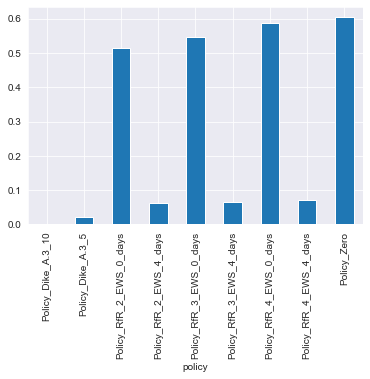

In [15]:
TCA_df["A.3_Expected Number of Deaths"]["mean"].plot.bar()

<AxesSubplot:xlabel='policy'>

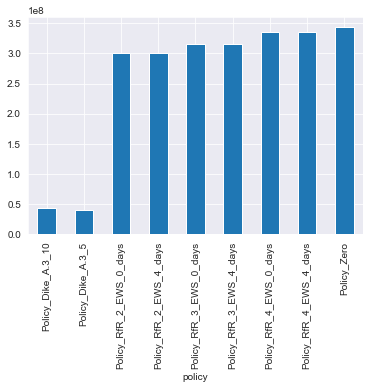

In [16]:
TCA_df["A.3 Total Costs"]["mean"].plot.bar()

In [17]:
# Save the aggegrated data to a CSV file
#TCA_df.to_csv("results/TCA3_results.csv")